# Executive Summary

> For this project, I began my journey by scraping some data from Reddit. I grabbed roughly 1,000 post titles from both `r/the_donald` and `r/politics` in order to perform various degrees of natural language processing analyses on them. 

 **********************************************************************************

> My first step once I got my scraped data tucked neatly into a Pandas Data Frame was to count-vectorize my post titles in order to allow my natural language processing tools to better understand the plainly written english text the same way that other machine learning tools read vectored columns. I included that step in a pipeline so as to then immediately run my vectorized data through its first model in order to overcome my instinctual apprehension of running a first model due to concern of it not performing well.  I used a multinomial Naive-Bayes classificatin model and scored around 75-80% on average from about 5 runs. 

> I had the most fun performing the EDA on this project due to some of the more presentation-friendly visualizations I was able to make. I first created 15 bar graphs showing the frequency of use of the top words between the two subreddits. Some of the more interesting takeways from this were **1.** the word "Trump" was most commonly found in the `r/politics` subreddit, which maybe due to the fact that in the echo chamber that is `r/the_donald`, they rarely refer to Trump by his name and are more likely to refer to him as "POTUS" or in a more North Korean fashion: "Supreme Leader." And **2.** that `r/the_donald` was more likely to have a positive sentiment rather than `r/politics`. This initially went against an instict I had that Trump supporters were more likely to be negative in genereal, but after this discovery I figured that Donald Trump supporters have a lot less to complain about right now than the liberal minded folks over in the echo chamber that is `r/politics`. BUT - `r/the_donald` was also more likely to have a negative sentiment than `r/politics` posts as well. This is most likely because `r/politics` posts are simply descriptions of articles from news sources, thus a more neutral tone - although the comment sections tend to favor more liberal discussion points.

> My final models were Random Forest and Extra Trees Classifiers. The Random Forest had a better accuracy score, but they seemed to perform about equally. 

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns

%matplotlib inline

/Users/jake/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/Users/jake/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# `r/politics`     

****************************************

# `r/the_donald`

# Read in `.csv` File Saved in Webscraping Notebook

In [2]:
df = pd.read_csv('scraped_2018-09-05 15:43:57.539375')

In [3]:
df.shape

(1993, 2)

> **check for balanced target classes**

In [4]:
df['subreddit'].value_counts()

The_Donald    1003
politics       990
Name: subreddit, dtype: int64

In [5]:
df.shape

(1993, 2)

# Change `subreddit` Categories to Numerical Values
> `r/the_donald == 1`

In [6]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'The_Donald' else 0)

In [7]:
df.iloc[1987,:]

title        WAHHHHHHHHH IM GOING HOME 😭😭 idiots. 🙄Democrat...
subreddit                                                    1
Name: 1987, dtype: object

In [8]:
df['subreddit'].value_counts()

1    1003
0     990
Name: subreddit, dtype: int64

# Train / Test Split

In [9]:
X = df['title']
y = df['subreddit']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

> check that target classes maintained balance

In [11]:
y_train.value_counts(normalize=True)

1    0.503347
0    0.496653
Name: subreddit, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

1    0.503006
0    0.496994
Name: subreddit, dtype: float64

# Get My First Model Out of the Way and Stop Getting Caught Up on Trying to Make My First Model Perfect

In [13]:
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', min_df=3)),
    ('nb', MultinomialNB())
])

pipe.fit(X_train, y_train)

pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8688085676037484, 0.7835671342685371)

> we can come back to modeling later...

# EDA

> **find the 15 most used words in each sub's titles and cast to list**

In [14]:
cv = CountVectorizer(stop_words='english', min_df=3)

cv.fit(df['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
df_cv = cv.transform(df['title'])

In [16]:
df_cv = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names())

In [17]:
df_cv['is_donald'] = df['subreddit'].get_values()

In [18]:
top_poli_words = list(df_cv[df_cv['is_donald'] == 0].drop(['is_donald'], axis=1).sum().sort_values(ascending=False)[:15].index)

In [19]:
top_don_words = list(df_cv[df_cv['is_donald'] == 1].drop(['is_donald'], axis=1).sum().sort_values(ascending=False)[:15].index)

In [20]:
top_words = list(df_cv.drop(['is_donald'], axis=1).sum().sort_values(ascending=False)[:15].index)

In [21]:
def plot_word_from_groupby(word, df=df_cv, by='is_donald'):
    df.groupby(by).sum()[word].plot(kind='barh')
    plt.title(f'Occurences of {word.title()}')
    plt.show();

> display bar graphs comparing the counts of how often each subreddit uses each of the 15 top words

In [59]:
for word in top_words:
    print(word)

trump
kavanaugh
hearing
woodward
book
brett
democrats
just
new
white
president
bob
says
court
confirmation


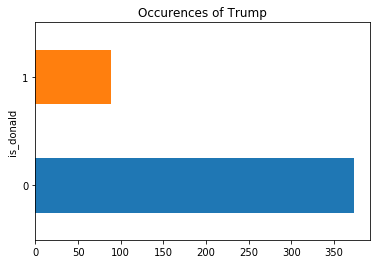

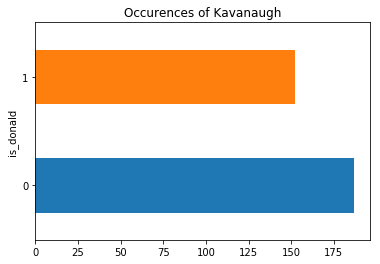

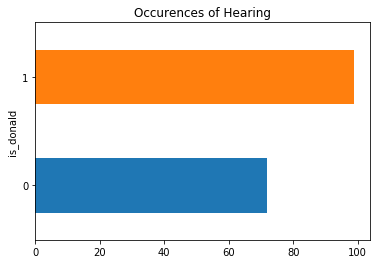

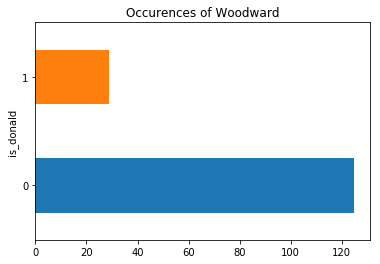

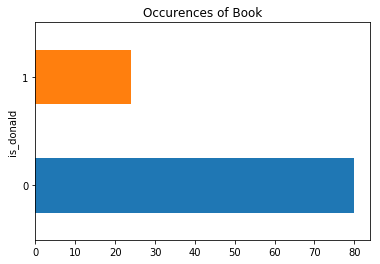

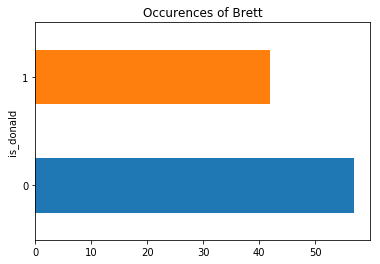

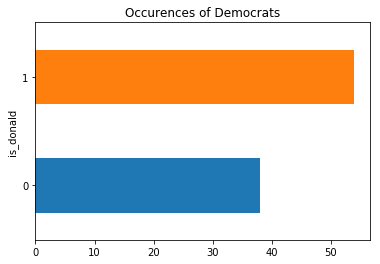

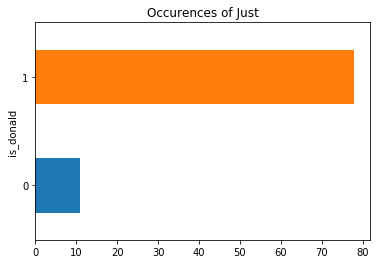

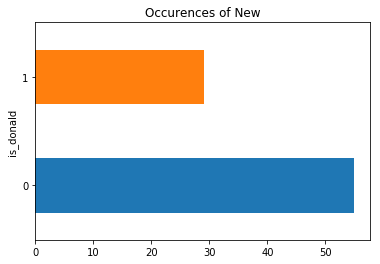

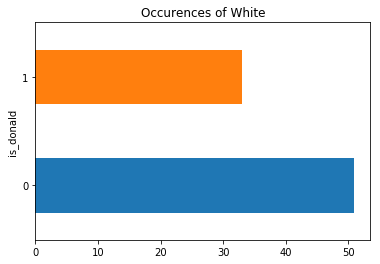

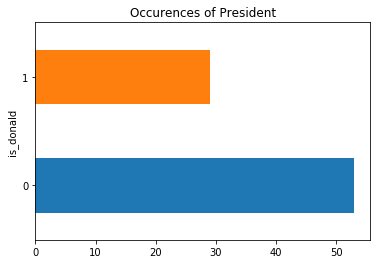

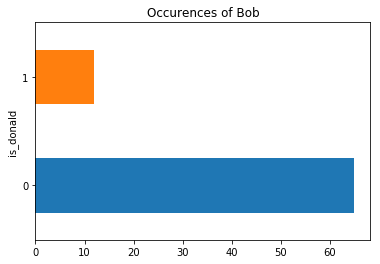

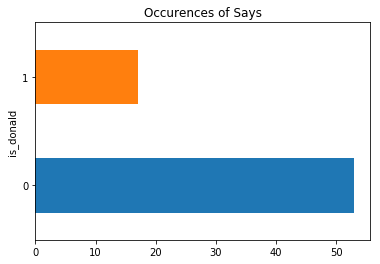

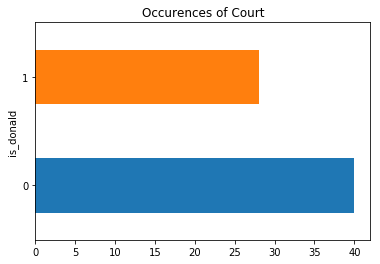

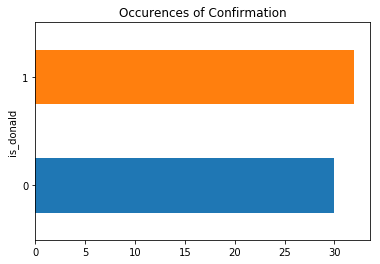

In [22]:
for word in top_words:
    plot_word_from_groupby(word)

> create word cloud of top words from `r/the_donald` and `r/politics`

In [23]:
only_poli = df[df['subreddit'] == 0]

poli_lst = []

for each in only_poli['title']:
    poli_lst.append(each)
poli_lst = str(poli_lst)

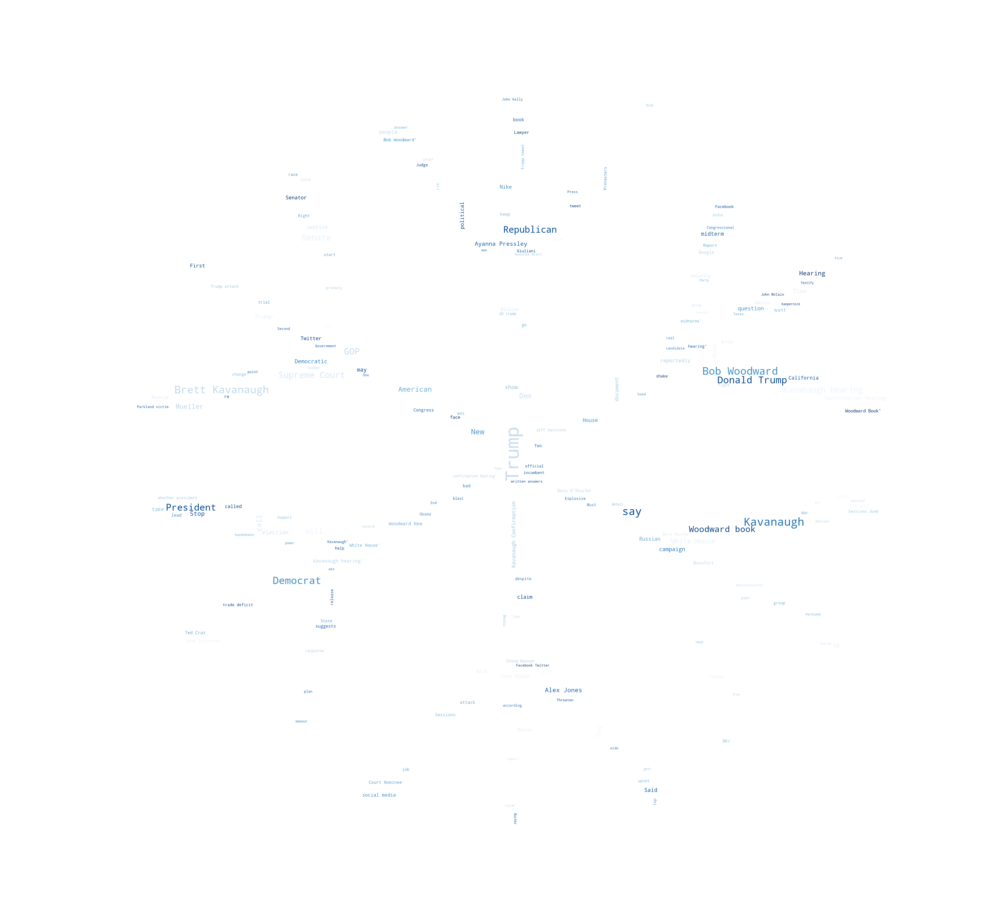

In [24]:
wave_mask = np.array(Image.open('./Images/flake.v1.jpg'))
 
# Make the figure
wordcloud = WordCloud(colormap='Blues',collocations=True,mask=wave_mask,background_color='white').generate(poli_lst)
plt.figure(figsize=(25,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('liberalsnowflake.pdf')
plt.show()

In [25]:
only_don = df[df['subreddit'] == 1]

don_lst = []

for each in only_don['title']:
    don_lst.append(each)
don_lst = str(don_lst)

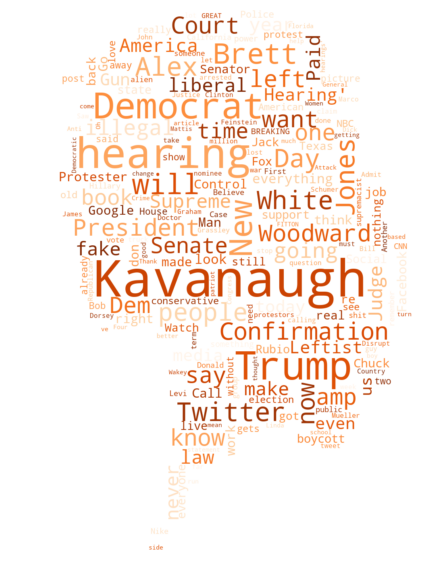

In [26]:
wave_mask = np.array(Image.open('./Images/largetrump2.v1.jpg'))
 
# Make the figure
wordcloud = WordCloud(width=800, height=400,colormap='Oranges',collocations=False,mask=wave_mask, background_color='white').generate(don_lst)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('trumpcloud.png')
plt.show()

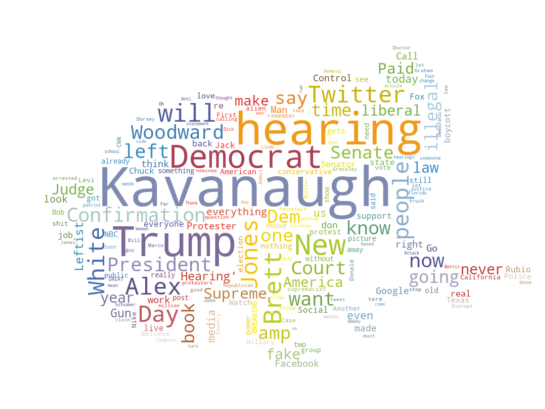

In [27]:
wave_mask = np.array(Image.open('./Images/gayfrog.jpg'))
    
# Make the figure
wordcloud = WordCloud(collocations=False,mask=wave_mask,background_color='white').generate(don_lst)
image_colors = ImageColorGenerator(wave_mask)
plt.figure(figsize=[9,16])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('gayfrog.jpg')
plt.show()

# back to modeling

In [28]:
class AverageWordLength(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def avg_word_length(self, line):
        return np.mean([len(each) for each in line.split()])
    
    def transform(self, df):
        return np.array(df.apply(self.avg_word_length)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [29]:
class CompoundScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_compound(self, line):
        return sia.polarity_scores(line)['compound']
    
    def transform(self, df):
        return np.array(df.apply(self.get_compound)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [30]:
class NegScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_neg(self, line):
        return sia.polarity_scores(line)['neg']
    
    def transform(self, df):
        return np.array(df.apply(self.get_neg)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [31]:
class PosScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_pos(self, line):
        return sia.polarity_scores(line)['pos']
    
    def transform(self, df):
        return np.array(df.apply(self.get_pos)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [32]:
class NeuScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_neu(self, line):
        return sia.polarity_scores(line)['neu']
    
    def transform(self, df):
        return np.array(df.apply(self.get_neu)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

> try  a simple pipeline that we set up in class using RandomForest

In [33]:
sia = SentimentIntensityAnalyzer()

pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('rf', RandomForestClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9886211512717537, 0.8016032064128257)

> try grid search

In [34]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer(min_df=1, stop_words=None)),
        ('awl', AverageWordLength()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('rf', RandomForestClassifier(min_samples_split=2,
                                  max_features=5, 
                                  n_estimators=500, 
                                  criterion='entropy',
                                  max_depth=15))
])

grid_params = {}

In [35]:
gs = GridSearchCV(pipe, param_grid=grid_params, verbose=2, n_jobs=-1, cv=3)

In [36]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV] ................................................. , total=   3.8s
[CV] ................................................. , total=   3.8s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [37]:
gs.best_params_

{}

In [38]:
gs.best_score_

0.7831325301204819

> Random forest confusion matrix

In [39]:
rf_predictions = gs.predict(X_test)

In [40]:
rf_matrix = confusion_matrix(y_test, rf_predictions)

In [41]:
rf_matrix

array([[211,  37],
       [ 57, 194]])

## The Accuracy Rate for the Random Forest is 82.4%

> predict some phrases

In [42]:
def rf_predict_sub(title):
    pred = gs.predict(pd.Series(title))
    if pred == 1:
        print("This sounds like a r/the_donald post!")
    else:
        print("This sounds like a r/politics post!")

In [43]:
rf_predict_sub('That time God-Emperor nearly STARED A MAN TO DEATH when '+ 
            'someone screamed GUN and the Secret Service leapt into action')

This sounds like a r/the_donald post!


In [44]:
rf_predict_sub('Trump reportedly exploded at his ex-lawyer after he heard Mueller'+ 
            'was looking into his relationship with Deutsche Bank: ')

This sounds like a r/politics post!


In [45]:
rf_predict_sub('white people')

This sounds like a r/politics post!


In [46]:
rf_predict_sub('god-emporer')

This sounds like a r/the_donald post!


> try Extra Trees

In [47]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('et', ExtraTreesClassifier())
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, ...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [48]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9979919678714859, 0.8136272545090181)

In [49]:
et_predictions = pipe.predict(X_test)

> Extra trees confusion matrix

In [50]:
et_matrix = confusion_matrix(y_test, et_predictions)

In [51]:
et_matrix

array([[209,  39],
       [ 54, 197]])

## The Accuracy Rate for the Extra Trees is 81.2%

> Extra Trees Predictions

In [52]:
def et_predict_sub(title):
    preds = pipe.predict(pd.Series(title))
    if preds == 1:
        print("This sounds like a r/the_donald post!")
    else:
        print("This sounds like a r/politics post!")

In [53]:
et_predict_sub('💩')

This sounds like a r/the_donald post!


In [54]:
et_predict_sub('That time God-Emperor nearly STARED A MAN TO DEATH when '+ 
            'someone screamed GUN and the Secret Service leapt into action')

This sounds like a r/the_donald post!


In [55]:
et_predict_sub('white people')

This sounds like a r/the_donald post!


In [56]:
et_predict_sub('💩')

This sounds like a r/the_donald post!


In [57]:
et_predict_sub('trump')

This sounds like a r/politics post!
